# 1.Preparing the data

In [1]:
import pyprind
import pandas as pd
from string import punctuation
import re
import numpy as np
df = pd.read_csv('../input/IMDB Dataset.csv', encoding='utf-8')

# 2.Convering a text into a list of integers

In [2]:
from collections import Counter
counts = Counter()
pbar = pyprind.ProgBar(len(df['review']), title='Counting words occurrences')
for i,review in enumerate(df['review']):
    text=''.join([c if c not in punctuation else ' '+c+' ' for c in review]).lower()
    df.loc[i,'review'] = text
    pbar.update()
    counts.update(text.split())

## Create a mapping
## Map each unique word to an integer
word_counts = sorted(counts, key=counts.get, reverse=True)
print(word_counts[:5])
word_to_int = {word: ii for ii, word in enumerate(word_counts, 1)}

mapped_reviews = []
pbar = pyprind.ProgBar(len(df['review']), title='Map reviews to ints')
for review in df['review']:
    mapped_reviews.append([word_to_int[word] for word in review.split()])
    pbar.update()

Counting words occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:38
Map reviews to ints


['the', '.', ',', 'and', 'a']


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


# 3.Filling zeros to a fixed-length sentence

In [3]:
## Define same-length sequences
## if sequence length < 200: left-pad with zeros
## if sequence length > 200: use the last 200 elements
sequence_length = 200 ## (Known as T in our RNN formulas)
sequences = np.zeros((len(mapped_reviews), sequence_length), dtype=int)
for i, row in enumerate(mapped_reviews):
    review_arr = np.array(row)
    sequences[i, -len(row):] = review_arr[-sequence_length:]

# 4.Preparing training and testing data

In [4]:
X_train = sequences[:25000,:]
y_train = df.loc[:24999, 'sentiment'].values
y_train[y_train=='positive'] = 1
y_train[y_train=='negative'] = 0
X_test = sequences[25000:,:]
y_test = df.loc[25000:, 'sentiment'].values
y_test[y_test=='positive'] = 1
y_test[y_test=='negative'] = 0

# 5.Bulid the model

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers
n_words = max(list(word_to_int.values())) + 1
mbed_size = 200
model = Sequential()
model.add(Embedding(n_words, mbed_size))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         20593400  
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          59648     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)      

# 5.1 Visualize model architecture

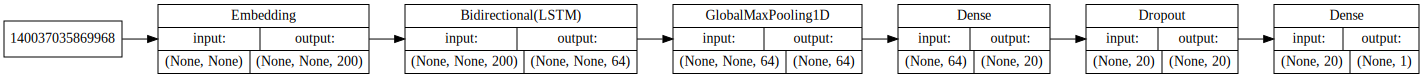

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='LR').create(prog='dot', format='svg'))

# 6.Train the model

In [7]:
batch_size = 100
epochs = 3
model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.3)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 17500 samples, validate on 7500 samples
Epoch 1/3
17500/17500 [==============================] - 85s 5ms/step - loss: 0.4951 - acc: 0.7535 - val_loss: 0.3312 - val_acc: 0.8609
Epoch 2/3
17500/17500 [==============================] - 81s 5ms/step - loss: 0.2039 - acc: 0.9238 - val_loss: 0.3189 - val_acc: 0.8711
Epoch 3/3
17500/17500 [==============================] - 82s 5ms/step - loss: 0.0891 - acc: 0.9714 - val_loss: 0.3779 - val_acc: 0.8587


In [8]:
prediction = model.predict(X_test)
y_pred = (prediction > 0.5).astype(int).reshape([1,-1])[0]
from sklearn.metrics import f1_score, confusion_matrix
print('F1-score: {0}'.format(f1_score(y_pred, y_test.astype(int))))
print('Confusion matrix:')
confusion_matrix(y_pred, y_test.astype(int))

F1-score: 0.8682581786030062
Confusion matrix:


array([[10280,  1233],
       [ 2194, 11293]])